# Classifying movie reviews
## a binary classification example

In [1]:
import keras
from keras.datasets import imdb

# IMDB dataset: 50,000개의 영화 리뷰 데이터.
# train을 위한 리뷰 25,000개, test를 위한 리뷰 25,000개를 담고 있다.
# 각각 긍정적인 리뷰 50%, 부정적인 리뷰 50% 이다.

# 단어의 종류를 10000개로 제한한다. 너무 생소한 단어는 제외된다.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


In [2]:
train_data.shape, test_data.shape

((25000,), (25000,))

In [3]:
# 긍정적인 리뷰이면 1, 부정적인 리뷰이면 0으로 라벨링되어있다.
print( train_labels[0] )

1


In [4]:
# 리뷰(문장)를 출력해보면 숫자들이 나오는데, 각 단어가 숫자로 임베딩(또는 인코딩)되어있는 것이다.
print( train_data[0] )

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# 단어들이 어떤 숫자로 임베딩되어있는지 
word_index = imdb.get_word_index()

reverse_word_index = dict(
    [(num, word) for (word, num) in word_index.items()])

for i in range(1, 10):
    print( i, reverse_word_index.get(i) )

for i in range(9991, 10000):
    print( i, reverse_word_index.get(i) )

1 the
2 and
3 a
4 of
5 to
6 is
7 br
8 in
9 it
9991 grabbing
9992 soulless
9993 unfairly
9994 grail
9995 retrospect
9996 edged
9997 retains
9998 shenanigans
9999 beaver


In [6]:
# 문장의 각 단어를 디코딩한다. join 함수는 각 요소를 이어붙여 하나의 string으로 만드는 함수이다.
decoded_review = ' '.join(
    [reverse_word_index.get(num - 3, '?') for num in train_data[0]])

# -3을 하는 이유는, 숫자의 0, 1, 2가 각각 “padding”, “start of sequence”, “unknown”으로 예약되어있기 때문이다.

print( decoded_review )

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [7]:
import numpy as np

# 문장을 학습에 이용할 때에는 포맷을 조금 바꿔주어야 한다.
# 10000개의 숫자를 가지는 배열을 만들어서, 각 i에 해당하는 단어가 문장에 포함되어있으면 1, 아니면 0으로 설정한다.
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
# 라벨은 int로 되어있는 것을 float로 변환한다,
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
from keras import models
from keras import layers

# 뉴럴 네트워크를 구성한다. Dense(Fully Connected) 레이어를 순서대로 3개 이어붙이고, 노드 수는 각각 16, 16, 1개이다. 
# 최종 출력은 sigmoid함수를 거친 1개의 숫자이며, 긍정적인 리뷰일 수록 이 숫자가 1에 가깝다.
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 구성한 네트워크를 학습할 때 어떤 optimizer, loss function을 쓸 것이고 어떤 metrics를 뽑을 것인지 설정한다.
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# train 시작
model.fit(x_train, y_train, epochs=10, batch_size=512)

Epoch 1/10
25000/25000 [==============================] - 6s 231us/step - loss: 0.4496 - acc: 0.8164
Epoch 2/10
25000/25000 [==============================] - 3s 131us/step - loss: 0.2552 - acc: 0.9091
Epoch 3/10
25000/25000 [==============================] - 3s 107us/step - loss: 0.1969 - acc: 0.9300
Epoch 4/10
25000/25000 [==============================] - 3s 105us/step - loss: 0.1669 - acc: 0.9408
Epoch 5/10
25000/25000 [==============================] - 2s 98us/step - loss: 0.1431 - acc: 0.9485
Epoch 6/10
25000/25000 [==============================] - 3s 101us/step - loss: 0.1266 - acc: 0.9561
Epoch 7/10
25000/25000 [==============================] - 2s 96us/step - loss: 0.1128 - acc: 0.9609
Epoch 8/10
25000/25000 [==============================] - 2s 97us/step - loss: 0.1010 - acc: 0.9650
Epoch 9/10
25000/25000 [==============================] - 2s 99us/step - loss: 0.0903 - acc: 0.9685
Epoch 10/10
25000/25000 [==============================] - 2s 95us/step - loss: 0.0810 - acc: 0

In [14]:
# 위에 출력된 것을 통해, epoch 10번을 거쳤을 때의 loss 및 accuracy 값을 확인할 수 있다. (train 데이터에 대해서)
# train 완료된 모델을 test하여, loss와 accuracy를 확인해본다.
results = model.evaluate(x_test, y_test)
print("loss:", results[0], "- accuracy:", results[1])

25000/25000 [==============================] - 5s 193us/step
loss: 0.44853377494812013 - accuracy: 0.8622


In [15]:
# test 결과를 확인하니, train때보다 loss는 높고 accuracy는 낮은, 나쁜 성능을 보인다.
# 즉, overfitting되었다. = train 데이터에 대해 과적합되었다.

# 적절한 epoch 수를 알기 위하여, epoch에 따른 loss 및 accuracy를 구해보고자 한다.
# 이를 위하여 train 데이터의 일부를 떼어내 validation 데이터로 이용한다.
x_val = x_train[:10000]  # validation 데이터는 1만 개
y_val = y_train[:10000]
partial_x_train = x_train[10000:] # train 데이터는 나머지 1만 5천 개
partial_y_train = y_train[10000:]

# 다시 학습 진행
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# 학습 과정의 validation 결과를 기록한다.
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 5s 342us/step - loss: 0.5206 - acc: 0.7933 - val_loss: 0.4146 - val_acc: 0.8543
Epoch 2/10
15000/15000 [==============================] - 2s 157us/step - loss: 0.3205 - acc: 0.9018 - val_loss: 0.3217 - val_acc: 0.8841
Epoch 3/10
15000/15000 [==============================] - 2s 148us/step - loss: 0.2354 - acc: 0.9261 - val_loss: 0.3089 - val_acc: 0.8737
Epoch 4/10
15000/15000 [==============================] - 2s 149us/step - loss: 0.1865 - acc: 0.9415 - val_loss: 0.2732 - val_acc: 0.8908
Epoch 5/10
15000/15000 [==============================] - 2s 143us/step - loss: 0.1542 - acc: 0.9523 - val_loss: 0.2748 - val_acc: 0.8891
Epoch 6/10
15000/15000 [==============================] - 2s 151us/step - loss: 0.1263 - acc: 0.9610 - val_loss: 0.2985 - val_acc: 0.8856
Epoch 7/10
15000/15000 [==============================] - 2s 145us/step - loss: 0.1061 - acc: 0.9696 - val_loss: 0.2972 - 

In [16]:
# 학습 과정의 validation 결과를 기록하였다.
# validation 데이터와 train 데이터 각각에 대한 loss, accuracy를 담고 있다.
history_dict = history.history
print( history_dict.keys() )

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


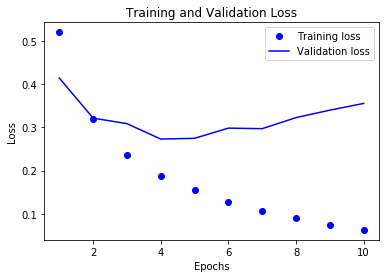

In [17]:
import matplotlib.pyplot as plt

# 그래프로 표현하여 epoch에 따른 loss, accuracy 변화를 눈으로 확인해본다.
epochs = range(1, len(history_dict['loss'])+1)

# training loss와 validation loss를 얻는다.
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# plotting
plt.plot(epochs, loss_values, 'bo', label='Training loss')  # training loss는 원 기호로 표시
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')  # validation loss는 선으로 표시
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

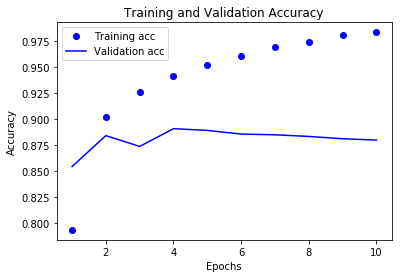

In [18]:
plt.clf()  # clears the figure

# training accuracy와 validation accuracy를 얻는다.
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

# plotting
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
# loss와 accuracy 그래프를 확인해봤을 때, epoch=4에서 과적합되지 않은 적절한 결과를 확인하였다.
# epoch=4로 다시 train한다.

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train
model.fit(x_train, y_train, epochs=4, batch_size=512)

# test
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 6s 232us/step - loss: 0.4589 - acc: 0.8191
Epoch 2/4
25000/25000 [==============================] - 4s 159us/step - loss: 0.2645 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 3s 120us/step - loss: 0.2031 - acc: 0.9291
Epoch 4/4
25000/25000 [==============================] - 5s 182us/step


In [23]:
# overfitting 문제는 해결되어 전보다 좋은 88% accuracy를 보인다.

print("loss:", results[0], "- acc:", results[1])

loss: 0.2921282673931122 - acc: 0.88344


끝. <br><br><br>